In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json, pickle
import argparse

import numpy as np
import pandas as pd
import torch
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter
from tbparse import SummaryReader


In [3]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.datasets as datasets
import src.utils as utils
import src.preprocess_lib as preprocess_lib
import src.conditioning_lib as conditioning_lib
from src.user_encoding_lib import UserEncoder


In [4]:
config_dir = 'runs/sweep_runs_corrected'
config_file = 'config.json'


In [104]:
df_experiment = pd.DataFrame()
for i, folder in enumerate(os.listdir(os.path.join(config_dir))):
    # Load config file
    with open(os.path.join(config_dir, folder, config_file), 'r') as f: config = json.load(f)
    config_flt = utils.flatten_dict(config)

    # Get validation metrics by reading tensorboard logs
    for tag in os.listdir(os.path.join(config_dir, folder, 'tensorboard')):
        tag_folder = os.path.join(config_dir, folder, 'tensorboard', tag)
        loss = SummaryReader(tag_folder).scalars["value"].values[-1]
        config_flt[tag] = loss
    df_config_val = pd.DataFrame(config_flt, index=[i])

    # Load test results
    if not os.path.exists(os.path.join(config_dir, folder, 'test_results.json')): df_test = pd.DataFrame()
    else:
        with open(os.path.join(config_dir, folder, 'test_results.json'), 'rb') as f: test_results = json.load(f)
        test_results_flt = utils.flatten_dict(test_results)
        ##add to dataframe
        df_test = pd.DataFrame(test_results_flt, index=[i])

    df_experiment = pd.concat([df_experiment, pd.concat([df_config_val, df_test], axis=1)], axis=0)


In [105]:
##change column names 
df_experiment.rename(columns={  'Loss_ELBO_val': 'ELBO (Validation)', 
                                'Loss_RLL_val': 'Reconstruction Log-likelihood (Validation)', 
                                'Loss_KL_val': 'KL Divergence (Validation)',
                                'data_ampute_params_b': 'Amputation Rate (b)',
                                'data_condition_tag_list': 'Conditions',
                                'model_distribution_dict_likelihood_dist_type': 'Likelihood Distribution',
                                'data_user_embedding_kwargs_model_kwargs_num_topics': 'Number of LDA Topics',
                                'data_user_embedding_kwargs_model_kwargs_num_clusters': 'Number of LDA Clusters',
                                'model_distribution_dict_likelihood_vocab_size': 'Pattern Dictionary Size',
                                'prob_metrics_loglikelihood_mean': 'Log-likelihood - Mean (Test)',
                                'prob_metrics_loglikelihood_std': 'Log-likelihood - Std (Test)',
                                'prob_metrics_loglikelihood_median': 'Log-likelihood - Median (Test)',
                                'prob_metrics_loglikelihood_min': 'Log-likelihood - Min (Test)',
                                'prob_metrics_loglikelihood_max': 'Log-likelihood - Max (Test)',
                                'prob_metrics_loglikelihood_quartile_lower': 'Log-likelihood - Lower Quartile (Test)',
                                'prob_metrics_loglikelihood_quartile_upper': 'Log-likelihood - Upper Quartile (Test)',
                                'sample_metrics_samples_rmse_mean': 'Sample Imputation RMSE - Mean (Test)',
                                'sample_metrics_samples_rmse_std': 'Sample Imputation RMSE - Std (Test)',
                                'sample_metrics_samples_rmse_median': 'Sample Imputation RMSE - Median (Test)',
                                'sample_metrics_samples_rmse_min': 'Sample Imputation RMSE - Min (Test)',
                                'sample_metrics_samples_rmse_max': 'Sample Imputation RMSE - Max (Test)',
                                'sample_metrics_samples_rmse_quartile_lower': 'Sample Imputation RMSE - Lower Quartile (Test)',
                                'sample_metrics_samples_rmse_quartile_upper': 'Sample Imputation RMSE - Upper Quartile (Test)',
                                'sample_metrics_mean_rmse_mean': 'Mean Imputation RMSE - Mean (Test)',
                                'sample_metrics_mean_rmse_std': 'Mean Imputation RMSE - Std (Test)',
                                'sample_metrics_mean_rmse_median': 'Mean Imputation RMSE - Median (Test)',
                                'sample_metrics_mean_rmse_min': 'Mean Imputation RMSE - Min (Test)',
                                'sample_metrics_mean_rmse_max': 'Mean Imputation RMSE - Max (Test)',
                                'sample_metrics_mean_rmse_quartile_lower': 'Mean Imputation RMSE - Lower Quartile (Test)',
                                'sample_metrics_mean_rmse_quartile_upper': 'Mean Imputation RMSE - Upper Quartile (Test)',
                              }, inplace=True)

In [106]:
## if df_expermient["Conditons"] does not have "users", replace def_experiment["Number of LDA Topics"] with 0
df_experiment.loc[df_experiment["Conditions"].apply(lambda x: "users" not in x), "Number of LDA Topics"] = 0
df_experiment.loc[df_experiment["Conditions"].apply(lambda x: "users" not in x), "Number of LDA Clusters"] = 0
## if df_expermient["Likelihood Distribution"] is not "dict-gauss", replace def_experiment['Pattern Dictionary Size'] with 0
df_experiment.loc[df_experiment["Likelihood Distribution"] != "dict-gauss", "Pattern Dictionary Size"] = 0

In [107]:
# df_experiment["Log-likelihood - IQR (Test)"] = df_experiment["Log-likelihood - Upper Quartile (Test)"] - df_experiment["Log-likelihood - Lower Quartile (Test)"]
# df_experiment["Sample Imputation RMSE - IQR (Test)"] = df_experiment["Sample Imputation RMSE - Upper Quartile (Test)"] - df_experiment["Sample Imputation RMSE - Lower Quartile (Test)"]
# df_experiment["Mean Imputation RMSE - IQR (Test)"] = df_experiment["Mean Imputation RMSE - Upper Quartile (Test)"] - df_experiment["Mean Imputation RMSE - Lower Quartile (Test)"]

## Visualization

In [108]:
relplot_kwargs = {  
                    'data': df_experiment,
                    'x': 'Number of LDA Topics',
                    'col': 'Amputation Rate (b)',
                    'size': 'Pattern Dictionary Size',
                    'hue': 'Likelihood Distribution',
                    'alpha': 0.7,
                    'style': 'Conditions',
                    # "kind":"line",
                    "sizes": (100, 400),
                    "style_order": ('["months", "weekdays", "users"]', '["months", "weekdays"]'),
                }

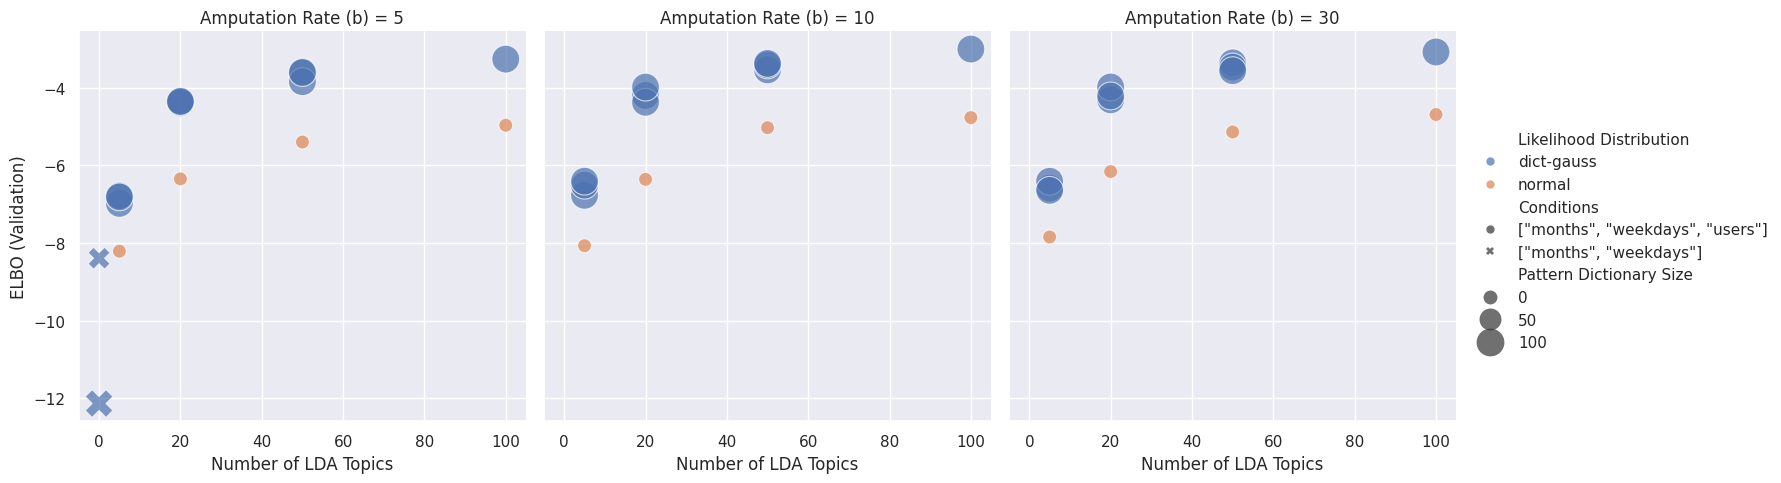

In [109]:
h=sns.relplot(y='ELBO (Validation)', **relplot_kwargs)
# h.set(xscale="log")
plt.show()

# h = sns.relplot(y='Log-likelihood - Median (Test)', size ="Log-likelihood - IQR (Test)",**relplot_kwargs)
# plt.show()4
# h = sns.relplot(y='Sample Imputation RMSE - Median (Test)', size="Sample Imputation RMSE - IQR (Test)", **relplot_kwargs)
# # plt.ylim([350,500])
# plt.show()
# h = sns.relplot(y='Mean Imputation RMSE - Median (Test)', size="Mean Imputation RMSE - IQR (Test)", **relplot_kwargs)
# # plt.ylim([350,500])
# plt.show()

